# Machine Learning in Crowd Modelling and Simulation
# Final Project
# Task 4: Extended Dynamic Model Decomposition - Linear System

### Group M:
1. Muhammad Waleed Bin Khalid
2. Qais Hamarneh
3. Yiming Zhang

# Useful Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy
from EDMD import EDMD
from tqdm import tqdm
from Observables import *
from utils import *
%load_ext autoreload
%autoreload 2

## A Linear Example

We work with the linear system 

$$x(n+1)=J x(n) \\
x(n+1)=\left[\begin{array}{cc}
0.9 & -0.1 \\
0.0 & 0.8
\end{array}\right] x(n)$$


In [4]:
J = np.array([[0.9, -0.1],[0, 0.8]])

def linear_system(x):
    x_next = x@J.T
    return x_next

## Actual Eigenvalues


In [5]:
lambda_0, lambda_1 = scipy.linalg.eig(J)[0]
v_0 = scipy.linalg.eig(J)[1][:,0]
v_1 = scipy.linalg.eig(J)[1][:,1]
w_01 = np.linalg.inv(scipy.linalg.eig(J)[1])
w_0 = w_01[0,:]
w_1 = w_01[1,:]
print(f"The matrix has eigenvalues {lambda_0} and {lambda_1}")
print(f"The matrix has eigenvectors {v_0} and {v_1}")
print(f"The matrix has left eigenvectors {w_0} and {w_1}")
w_01

The matrix has eigenvalues (0.9+0j) and (0.8+0j)
The matrix has eigenvectors [1. 0.] and [0.70710678 0.70710678]
The matrix has left eigenvectors [ 1. -1.] and [0.         1.41421356]


array([[ 1.        , -1.        ],
       [ 0.        ,  1.41421356]])

## Koopman Eigenfunction
This makes the Koopman eigenfunction as follows 
$$
\varphi_{n_{1}, n_{2}, \ldots, n_{N}}(\boldsymbol{x})=\prod_{i=1}^{N}\left(\boldsymbol{w}_{i}^{*} \boldsymbol{x}\right)^{n_{i}}
$$

and the corresponding Koopman eigenvalues are 

$$
\prod_{i=1}^{N} \lambda_{i}^{n_{i}}
$$
where $\boldsymbol{w}_{i}$ is the left eigenvector with cooresponding eigen values $\mu_i$


Hence for our linear case we get
$$
\varphi_{i,j} = (\frac{x}{\sqrt{2}}-\frac{y}{\sqrt{2}})^i(y)^j
$$
and
$$
\lambda_{i,j} = (0.9)^i(0.8)^j
$$

We will plot the results now

In [6]:
def linear_koopman_eigenfunction(X, Y, i,j):
    eigenfunc = (X/np.sqrt(2) - Y/np.sqrt(2))**i * (Y)**j
    eigenval = 0.9**i * 0.8**j
    return [eigenval, eigenfunc]

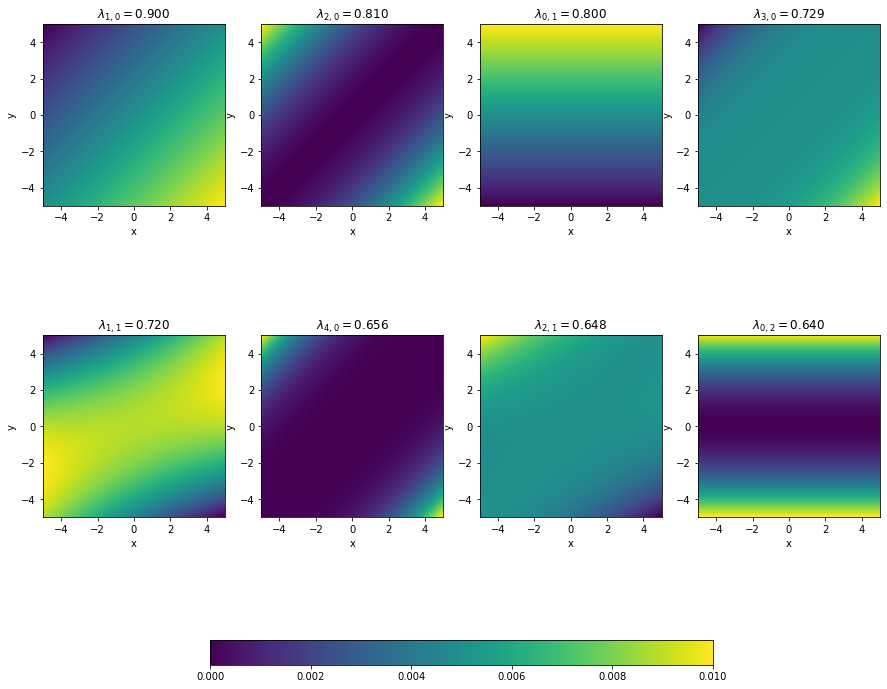

In [7]:
x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)
X, Y = np.meshgrid(x,y)
# Flip array because we want numbering to start from bottom of array instead of the default top from numpy
X = np.flipud(X)
Y = np.flipud(Y)

ij_pair = [(1,0), (2,0), (0,1), (3,0), (1,1), (4,0), (2,1), (0,2)]
fig, axs = plt.subplots(2,4, figsize=(15,15))
axs = axs.flatten()
analytical_eigenval_list = []
analytical_eigenfunc_list = []

for index, ij in enumerate(ij_pair):
    i, j = ij
    analytical_eigenval = linear_koopman_eigenfunction(X, Y, i,j)[0]
    analytical_eigenval_list.append(analytical_eigenval)
    analytical_eigenfunc = linear_koopman_eigenfunction(X, Y, i,j)[1]
    analytical_eigenfunc_normalized = analytical_eigenfunc / np.linalg.norm(analytical_eigenfunc, np.inf)
    analytical_eigenfunc_list.append(analytical_eigenfunc_normalized)
    s = axs[index].imshow(analytical_eigenfunc_normalized,extent=[-5,5,-5,5])
    axs[index].set_title(f"$\lambda_{{{i},{j}}} = ${analytical_eigenval:0.3f}")
    axs[index].set_xlabel('x'); axs[index].set_ylabel('y')
#     axs[index].set_xticks(x); axs[index].set_yticks(y)


fig.colorbar(s, ax=axs[:], shrink=0.6, location='bottom')
# fig.savefig('figures/linear_analytical_eigenfuncs.png')

## Generating Data

In [8]:
initial_conditions = np.array(np.meshgrid(np.linspace(-2, 2, 8), np.linspace(-2, 2, 8))).T.reshape(-1, 2)

In [9]:
x_linear = []
dt = 0.1
t_range = np.arange(0,5,dt)
x_sol = pd.DataFrame()
for i, ic in enumerate(initial_conditions):
    ic = ic.reshape(-1, ic.shape[0])
    x_linear = []
    y_linear = []
    x_linear.append(ic)
    for delta_t in t_range:
        x_linear.append(linear_system(x_linear[-1]))
        y_linear.append(x_linear[-1])
    y_linear.append(linear_system(x_linear[-1]))
    x_linear = np.array(x_linear).squeeze()
    y_linear = np.array(y_linear).squeeze()
    xy_linear = np.concatenate((x_linear, y_linear), axis=1)
    if x_sol is None:
        x_df = pd.DataFrame(xy_linear, columns=['x1', 'x2', 'y1', 'y2'])
        x_df.insert(0,'ID', i)
    else:
        x_df = pd.DataFrame(xy_linear, columns=['x1', 'x2', 'y1', 'y2'])
        x_df.insert(0,'ID', i)
        x_sol = pd.concat([x_sol, x_df], axis=0)
x_sol

,ID,x1,x2,y1,y2
0,0,-2.000000,-2.000000,-1.600000,-1.600000
1,0,-1.600000,-1.600000,-1.280000,-1.280000
2,0,-1.280000,-1.280000,-1.024000,-1.024000
3,0,-1.024000,-1.024000,-0.819200,-0.819200
4,0,-0.819200,-0.819200,-0.655360,-0.655360
...,...,...,...,...,...
46,63,0.000070,0.000070,0.000056,0.000056
47,63,0.000056,0.000056,0.000045,0.000045
48,63,0.000045,0.000045,0.000036,0.000036
49,63,0.000036,0.000036,0.000029,0.000029


## Progress of the system - Analytical

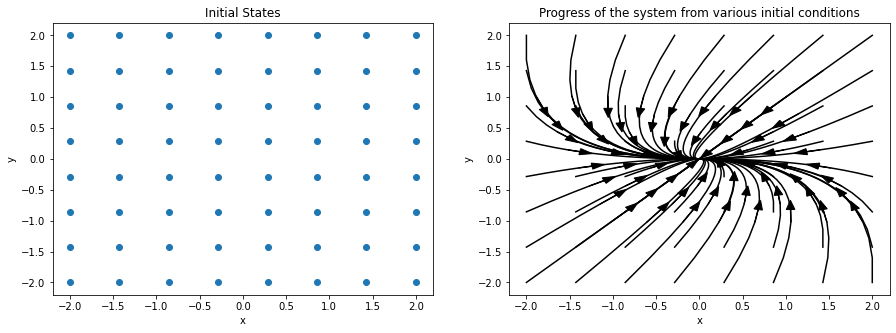

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].scatter(initial_conditions[:,0], initial_conditions[:,1])
plot_data(x_sol, axs[1])
axs[0].set_title('Initial States'); axs[1].set_title('Progress of the system from various initial conditions')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); axs[1].set_xlabel('x'); axs[1].set_ylabel('y');
# fig.savefig('figures/linear_system_analytical_progress.png')

## Dictionary: Case - Hermite Polynomials

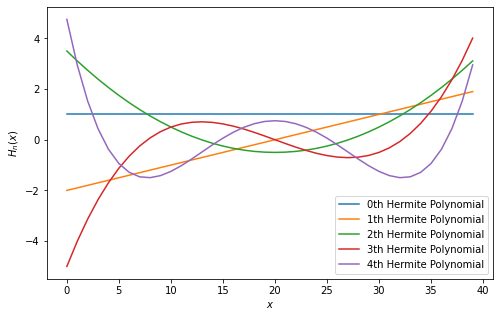

In [11]:
hermite_polys = []
a = np.arange(-2,2, 0.1)
hermite_polys.append(a)
fig, ax = plt.subplots(figsize=(8,5))
for i in range(5):
    hermite_poly = scipy.special.hermite(i, monic=True)
    hermite_polys.append(hermite_poly(a))
    ax.plot(hermite_polys[-1], label=f'{i}th Hermite Polynomial')
ax.set_xlabel('$x$')
ax.set_ylabel('$H_n(x)$')
plt.legend()
fig.savefig('figures/hermite_polys.png')

In [12]:
hermitian_observables = HermitePairs(5) # We will use the Hermite Pair dictionary as observables
hermitian_observables.fit(x_sol.iloc[:,0:3])

,ID,x1,x2,H0(x1)H0(x2),H0(x1)H1(x2),H0(x1)H2(x2),H0(x1)H3(x2),H0(x1)H4(x2),H1(x1)H0(x2),H1(x1)H1(x2),...,H3(x1)H0(x2),H3(x1)H1(x2),H3(x1)H2(x2),H3(x1)H3(x2),H3(x1)H4(x2),H4(x1)H0(x2),H4(x1)H1(x2),H4(x1)H2(x2),H4(x1)H3(x2),H4(x1)H4(x2)
0,0,-2.000000,-2.000000,1.0,-4.000000,14.000000,-40.000000,76.000000,-4.000000,1.600000e+01,...,-40.000000,1.600000e+02,-560.000000,1.600000e+03,-3040.000000,76.000000,-304.000000,1064.000000,-3040.000000,5776.000000
1,0,-1.600000,-1.600000,1.0,-3.200000,8.240000,-13.568000,-6.022400,-3.200000,1.024000e+01,...,-13.568000,4.341760e+01,-111.800320,1.840906e+02,81.711923,-6.022400,19.271680,-49.624576,81.711923,36.269302
2,0,-1.280000,-1.280000,1.0,-2.560000,4.553600,-1.417216,-23.693527,-2.560000,6.553600e+00,...,-1.417216,3.628073e+00,-6.453435,2.008501e+00,33.578846,-23.693527,60.655429,-107.890845,33.578846,561.383224
3,0,-1.024000,-1.024000,1.0,-2.048000,2.194304,3.698065,-20.739462,-2.048000,4.194304e+00,...,3.698065,-7.573638e+00,8.114680,1.367569e+01,-76.695887,-20.739462,42.474418,-45.508684,-76.695887,430.125282
4,0,-0.819200,-0.819200,1.0,-1.638400,0.684355,5.432353,-13.006495,-1.638400,2.684355e+00,...,5.432353,-8.900368e+00,3.717656,2.951046e+01,-70.655880,-13.006495,21.309842,-8.901054,-70.655880,169.168920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,63,0.000070,0.000070,1.0,0.000139,-2.000000,-0.000836,12.000000,0.000139,1.942669e-08,...,-0.000836,-1.165601e-07,0.001673,6.993608e-07,-0.010035,12.000000,0.001673,-23.999999,-0.010035,143.999994
47,63,0.000056,0.000056,1.0,0.000112,-2.000000,-0.000669,12.000000,0.000112,1.243308e-08,...,-0.000669,-7.459849e-08,0.001338,4.475909e-07,-0.008028,12.000000,0.001338,-24.000000,-0.008028,143.999996
48,63,0.000045,0.000045,1.0,0.000089,-2.000000,-0.000535,12.000000,0.000089,7.957172e-09,...,-0.000535,-4.774303e-08,0.001070,2.864582e-07,-0.006423,12.000000,0.001070,-24.000000,-0.006423,143.999998
49,63,0.000036,0.000036,1.0,0.000071,-2.000000,-0.000428,12.000000,0.000071,5.092590e-09,...,-0.000428,-3.055554e-08,0.000856,1.833332e-07,-0.005138,12.000000,0.000856,-24.000000,-0.005138,143.999999


# The EDMD Algorithm

In [13]:
linear_edmd = EDMD(x_sol, 2, hermitian_observables)
linear_edmd.fit()

In [14]:
x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)
X, Y = np.meshgrid(x,y)
# Flip array because we want numbering to start from bottom of array instead of the default top from numpy
X = np.flipud(X)
Y = np.flipud(Y)

## Plotting the first 8 eigenfunctions 
We comparing similarity with analytical eigenfunctions

In [15]:
def make_eigenfunction(X, Y, eigvec_log):
    eigenfunction = []
    for i in range(Y.shape[1]):
        temp = pd.DataFrame(np.array([X[:,i], Y[:,i]]).T, columns=['x', 'y'])
        temp.insert(0, 'ID', 0)
        a = linear_edmd.calculate_eigenfunction(temp, eigvec_log)
        eigenfunction.append(a)
    eigenfunction = np.array(eigenfunction).T
    return eigenfunction.real

Note that the 6th eigenfunction is flipped which is in line with the results from the paper

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.38s/it]


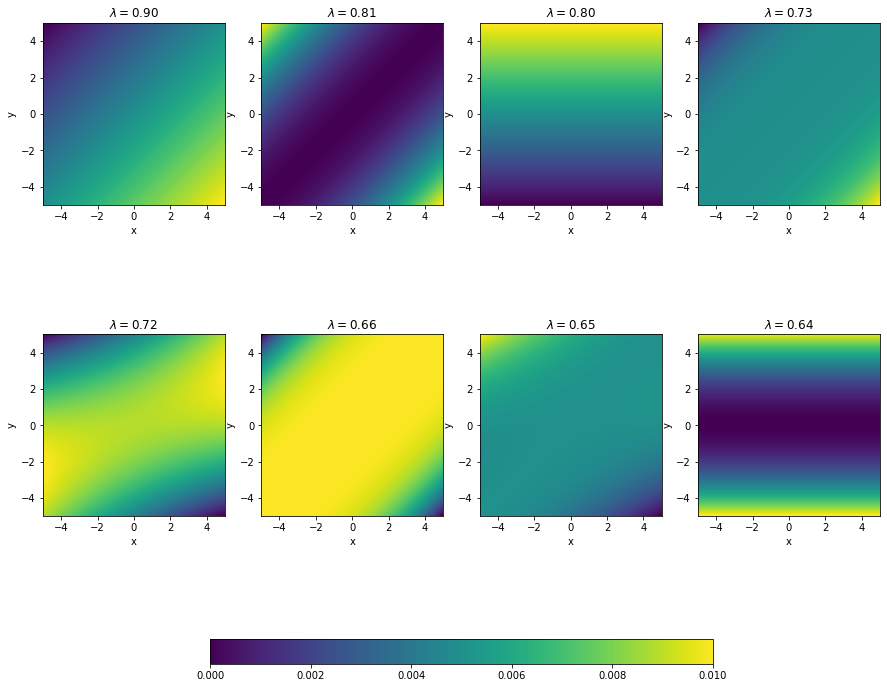

In [57]:
fig, axs = plt.subplots(2,4, figsize=(15,15))
axs = axs.flatten()
eigenfunc_list = []
for index in tqdm(range(len(axs))):
    eigen_func = make_eigenfunction(X,Y, index+1)
    eigen_func_normalized = eigen_func / np.linalg.norm(eigen_func, np.inf)
    eigenfunc_list.append(eigen_func_normalized)
    # Normalize with infinity Norm
    s = axs[index].imshow(eigen_func_normalized,extent=[-5,5,-5,5])
    axs[index].set_title(f"$\lambda = ${linear_edmd.eigenvalues[index+1].real:0.2f}")
    axs[index].set_xlabel('x'); axs[index].set_ylabel('y')

fig.colorbar(s, ax=axs[:], shrink=0.6, location='bottom')
# fig.savefig('figures/linear_edmd_eigenfunctions.png')

# Difference between eigenvalues and eigenfunctions

In [55]:
print(f"MSE between first 8 eigenvalues compared to analytical solution is {np.sum((linear_edmd.eigenvalues[1:9].real -  np.array(analytical_eigenval_list[:]))**2)/8}")
diff = eigen_func_normalized - analytical_eigenfunc_normalized
diff = diff.flatten()
print(f"MSE between last eigenfunction compared to analytical solution is {np.sum(diff**2)}")


MSE between first 8 eigenvalues compared to analytical solution is 2.3511125678289483e-26
MSE between last eigenfunction compared to analytical solution is 4.253910508301399e-21


In [66]:
for i in range(8):
    diff = eigenfunc_list[i] - analytical_eigenfunc_list[i]
    diff = diff.flatten()
    mse = np.sum(diff**2)
    print(f"MSE for {i}th eigenfunction compared to analytical solution {mse}")

MSE for 0th eigenfunction compared to analytical solution 7.391613189545708e-18
MSE for 1th eigenfunction compared to analytical solution 7.69748371134203e-23
MSE for 2th eigenfunction compared to analytical solution 6.554308229154267e-18
MSE for 3th eigenfunction compared to analytical solution 6.420870771953517e-20
MSE for 4th eigenfunction compared to analytical solution 6.320938578979514e-23
MSE for 5th eigenfunction compared to analytical solution 2.3350922391837754
MSE for 6th eigenfunction compared to analytical solution 2.3108595830865163e-19
MSE for 7th eigenfunction compared to analytical solution 4.253910508301399e-21


## Matrix B

Matrix B can be selected such that the original state is recovered from the observables. In our case the observables are as below

$$
\begin{aligned}
\mathcal{D}=&\left\{\psi_{0}, \psi_{1}, \psi_{2}, \ldots\right\} \\
&\left\{H_{0}(x) H_{0}(y), H_{1}(x) H_{0}(y), H_{2}(x) H_{0}(y), H_{3}(x) H_{0}(y), H_{4}(x) H_{0}(y),\right.\\
& H_{0}(x) H_{1}(y), H_{1}(x) H_{1}(y), H_{2}(x) H_{1}(y), H_{3}(x) H_{1}(y), H_{4}(x) H_{1}(y), \\
& H_{0}(x) H_{2}(y), H_{1}(x) H_{2}(y), H_{2}(x) H_{2}(y), H_{3}(x) H_{2}(y), H_{4}(x) H_{2}(y), \\
& H_{0}(x) H_{3}(y), H_{1}(x) H_{3}(y), H_{2}(x) H_{3}(y), H_{3}(x) H_{3}(y), H_{4}(x) H_{3}(y), \\
&\left.H_{0}(x) H_{4}(y), H_{1}(x) H_{4}(y), H_{2}(x) H_{4}(y), H_{3}(x) H_{4}(y), H_{4}(x) H_{4}(y)\right\},
\end{aligned}
$$

So we see to recover x we need the second element and to recover y we need the sixth element. Hence B becomes:

$$
\boldsymbol{B}=\left[\begin{array}{lll}
0 & 0 \\
1 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 1 \\
0 & 0 \\
\vdots & \vdots
\end{array}\right]
$$

In [16]:
B = np.zeros((25, 2))
B[5,0] = 1/2
B[1,1] = 1/2

However since we do not want to supply B each time we use the least squares method to calculate B. This is because

$$
X = \psi(X) B
$$
$$
B = \min _{B}\left\|X -\psi(X) B\right\|^{2}
$$

This can be seen in the method `EDMD.estimate_B`

## Eigen Modes and Predictions

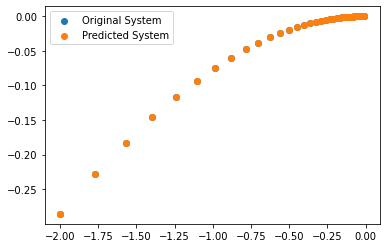

In [17]:
x_actual = x_sol[x_sol['ID'] == 3].iloc[:,:3]
initial_values = x_actual.iloc[0:1,0:3]
x_predict = linear_edmd.predict(initial_values, t_end=51)
fig, axs = plt.subplots(1,1, sharex=True, sharey=True)
axs.scatter(x_actual.iloc[:,1].to_numpy().real, x_actual.iloc[:,2].to_numpy().real, label='Original System')
axs.scatter(x_predict.iloc[:,1].to_numpy().real, x_predict.iloc[:,2].to_numpy(), label='Predicted System')
plt.legend()

In [18]:
initial_values = pd.DataFrame(initial_conditions, columns=['x1', 'x2'])
initial_values.insert(0, 'ID', range(len(initial_values)))
x_predict_edmd = linear_edmd.predict(initial_values, t_end=20)
x_predict_edmd

,ID,x1,x2
0,0.0,-2.000000,-2.000000
1,1.0,-2.000000,-1.428571
2,2.0,-2.000000,-0.857143
3,3.0,-2.000000,-0.285714
4,4.0,-2.000000,0.285714
...,...,...,...
0,63.0,0.056295,0.056295
0,63.0,0.045036,0.045036
0,63.0,0.036029,0.036029
0,63.0,0.028823,0.028823


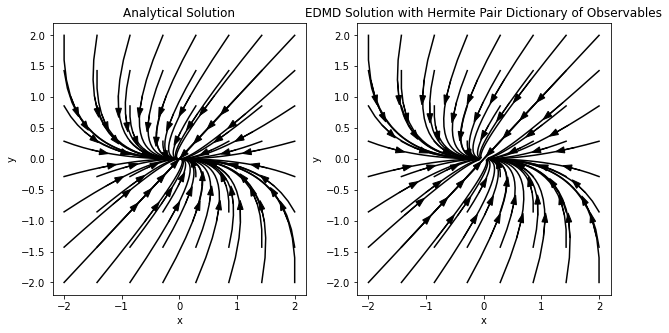

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
plot_data(x_predict_edmd, axs[1])
plot_data(x_sol, axs[0])
axs[0].set_title('Analytical Solution')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); 
axs[1].set_title('EDMD Solution with Hermite Pair Dictionary of Observables')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y'); 
# fig.savefig('figures/linear_edmd_solution.png')

In [70]:
# linear_edmd.eigenmodes

## Lets try the same with the identity dictionary

EDMD with the identity dictionary is just the DMD method

In [71]:
identity_observables = Identity() # We will use the Hermite Pair dictionary as observables
identity_observables.fit(x_sol.iloc[:,0:3])

,ID,x1,x2,x1,x2
0,0,-2.000000,-2.000000,-2.000000,-2.000000
1,0,-1.600000,-1.600000,-1.600000,-1.600000
2,0,-1.280000,-1.280000,-1.280000,-1.280000
3,0,-1.024000,-1.024000,-1.024000,-1.024000
4,0,-0.819200,-0.819200,-0.819200,-0.819200
...,...,...,...,...,...
46,63,0.000070,0.000070,0.000070,0.000070
47,63,0.000056,0.000056,0.000056,0.000056
48,63,0.000045,0.000045,0.000045,0.000045
49,63,0.000036,0.000036,0.000036,0.000036


In [72]:
linear_dmd = EDMD(x_sol, 2, identity_observables)
linear_dmd.fit()
print(f"Right eigenvectors form EDMD with identity dictionary {linear_dmd.eigenvectors_right[:,0]}")
print(f"Right eigenvectors form EDMD with identity dictionary {linear_dmd.eigenvectors_right[:,1]}")
print(f"Left eigenvectors form EDMD with identity dictionary {linear_dmd.eigenvectors_left_conj[0,:]}")
print(f"Left eigenvectors form EDMD with identity dictionary {linear_dmd.eigenvectors_left_conj[1,:]}")
print(f"Eigenvalues form EDMD with identity dictionary {linear_dmd.eigenvalues}")

Right eigenvectors form EDMD with identity dictionary [ 0.70710678 -0.70710678]
Right eigenvectors form EDMD with identity dictionary [0. 1.]
Left eigenvectors form EDMD with identity dictionary [1.41421356 0.        ]
Left eigenvectors form EDMD with identity dictionary [1. 1.]
Eigenvalues form EDMD with identity dictionary [0.9+0.j 0.8+0.j]


## Predicting with DMD

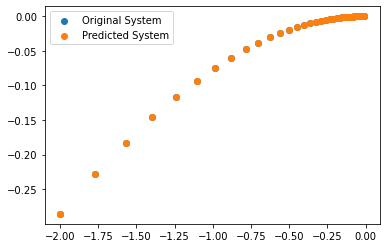

In [24]:
x_actual = x_sol[x_sol['ID'] == 3].iloc[:,:3]
initial_values = x_actual.iloc[0:1,0:3]
x_predict = linear_dmd.predict(initial_values, t_end=51)
fig, axs = plt.subplots(1,1, sharex=True, sharey=True)
axs.scatter(x_actual.iloc[:,1].to_numpy().real, x_actual.iloc[:,2].to_numpy().real, label='Original System')
axs.scatter(x_predict.iloc[:,1].to_numpy().real, x_predict.iloc[:,2].to_numpy(), label='Predicted System')
plt.legend()

In [27]:
initial_values = pd.DataFrame(initial_conditions, columns=['x1', 'x2'])
initial_values.insert(0, 'ID', range(len(initial_values)))
x_predict_dmd = linear_dmd.predict(initial_values, t_end=20)
x_predict_dmd

,ID,x1,x2
0,0.0,-2.000000,-2.000000
1,1.0,-2.000000,-1.428571
2,2.0,-2.000000,-0.857143
3,3.0,-2.000000,-0.285714
4,4.0,-2.000000,0.285714
...,...,...,...
0,63.0,0.056295,0.056295
0,63.0,0.045036,0.045036
0,63.0,0.036029,0.036029
0,63.0,0.028823,0.028823


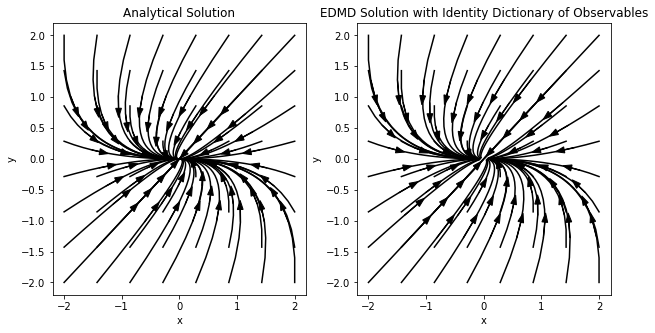

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
plot_data(x_sol, axs[0])
plot_data(x_predict_dmd, axs[1])
axs[0].set_title('Analytical Solution')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); 
axs[1].set_title('EDMD Solution with Identity Dictionary of Observables')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y'); 
# fig.savefig('figures/linear_dmd_solution.png')